# Import 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
import os
import mlflow.sklearn
import time
from nltk import word_tokenize, pos_tag
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk import FreqDist

# from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/skanderzahi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skanderzahi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# nltk.download("averaged_perceptron_tagger")
# nltk.download("punkt")
# nltk.download("maxent_ne_chunker")  # Souvent requis aussi
# nltk.download("words")
# nltk.download("averaged_perceptron_tagger_eng")

In [6]:
print(f"Python version: {sys.version}")
print(f"MLflow version: {mlflow.__version__}")

Python version: 3.11.14 | packaged by conda-forge | (main, Oct 13 2025, 14:29:50) [Clang 19.1.7 ]
MLflow version: 3.2.0


In [7]:
# df_train = pd.read_csv("df_train.csv")
# df_test = pd.read_csv("df_test.csv")
# df_train.shape, df_test.shape

In [8]:
df_train = pd.read_csv("train_100K.csv")
df_val = pd.read_csv("val_100K.csv")
df_test = pd.read_csv("test_100K.csv")
df_train.shape, df_val.shape, df_test.shape

((64000, 6), (16000, 6), (20000, 6))

In [9]:
df_train["target"].value_counts(), df_test["target"].value_counts()

(target
 1    32046
 0    31954
 Name: count, dtype: int64,
 target
 1    10023
 0     9977
 Name: count, dtype: int64)

In [10]:
lemmatizer = WordNetLemmatizer()

# ---------------------------

In [ ]:
# df_train = pd.read_csv("df_train.csv")
# df_test = pd.read_csv("df_test.csv")

In [185]:
df_train["target"].value_counts(), df_test["target"].value_counts()

(target
 0    80000
 1    80000
 Name: count, dtype: int64,
 target
 1    20000
 0    20000
 Name: count, dtype: int64)

In [186]:
# Creer un set validation à partir de train
df_train, df_val = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train["target"]
)
df_train.shape, df_val.shape, df_test.shape

((128000, 6), (32000, 6), (40000, 6))

In [14]:
# Définir le nom de l'expérience
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

# ________

# TF-IDF

## Preprocess 1

Prétraitement aggressif : word_tokenize, stopwords, suppression ponctuation, hashtag, mention...

In [134]:
# Preprocess_1
def preprocess_1(text):
    from nltk.corpus import stopwords

    # Convertir en minuscules
    text = text.lower()

    # Supprimer les URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Supprimer les mentions et hashtags
    text = re.sub(r"\@\w+|\#", "", text)

    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub(r"[^\w\s]", "", text)

    # Supprimer les chiffres
    text = re.sub(r"\d+", "", text)

    # Tokenisation
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joindre les tokens en une seule chaîne
    text = " ".join(tokens)

    return text

In [135]:
# preprocess_1 train + test
df_train["text_preprocess_1"] = df_train["text"].apply(preprocess_1)
df_test["text_preprocess_1"] = df_test["text"].apply(preprocess_1)

In [136]:
pd.set_option("display.max_colwidth", None)

In [137]:
# Vérification d'un échantillon
print("Exemple de texte avant/après preprocess_1:")
print("Avant:", df_train["text"].iloc[10])
print("Après:", df_train["text_preprocess_1"].iloc[10])

Exemple de texte avant/après preprocess_1:
Avant: my eyes burn 
Après: eye burn


In [81]:
def vectorize_tf_idf(X_train_texts, X_test_texts, vectorizer=None):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.90)
    X_train = vectorizer.fit_transform(X_train_texts)
    X_test = vectorizer.transform(X_test_texts)
    return X_train, X_test, vectorizer

In [158]:
X_train, X_test, vectorizer = vectorize_tf_idf(
    df_train["text_preprocess_1"], df_test["text_preprocess_1"]
)
y_train = df_train["target"]
y_test = df_test["target"]

In [140]:
# # Entraînement et évaluation du modèle avec MLflow
# with mlflow.start_run(run_name="Logistic_Regression_TFIDF_preprocess_1"):

#     # Log des paramètres
#     mlflow.log_param("model_type", "LogisticRegression")  # Type de modèle
#     mlflow.log_param("vectorizer", "TF-IDF")  # Type de vectoriseur
#     mlflow.log_param("min_df", 2)  # Seuil de fréquence minimale
#     mlflow.log_param("max_df", 0.90)  # Seuil de fréquence maximale
#     mlflow.log_param("max_features", 1000)  # Nombre maximum de caractéristiques
#     mlflow.log_param("ngram_range", "(1, 2)")  # Plage de n-grammes
#     mlflow.log_param("preprocessing", "preprocess_1")  # Méthode de prétraitement
#     mlflow.log_param("random_state", 42)
#     mlflow.log_param("max_iter", 1000)

#     # Mesurer le temps d'exécution
#     start_time = time.time()

#     # Construction de la régression logistique
#     model = LogisticRegression(random_state=42, max_iter=1000)
#     model.fit(X_train, y_train)

#     training_time = time.time() - start_time
#     mlflow.log_metric("training_time_seconds", training_time)

#     # Prédire les probabilités pour les ensembles d'entraînement et de test
#     y_train_pred = model.predict(X_train)
#     y_train_pred_proba = model.predict_proba(X_train)[:, 1]

#     y_test_pred = model.predict(X_test)
#     y_test_pred_proba = model.predict_proba(X_test)[:, 1]

#     # Calcul des métriques
#     def calcul_metriques(y_true, y_pred, y_pred_proba):

#         accuracy = accuracy_score(y_true, y_pred)
#         precision = precision_score(y_true, y_pred)
#         recall = recall_score(y_true, y_pred)
#         f1 = f1_score(y_true, y_pred)
#         roc_auc = roc_auc_score(y_true, y_pred_proba)

#         return accuracy, precision, recall, f1, roc_auc

#     # Calcul des métriques pour les ensembles d'entraînement et de test

#     train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
#         calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
#     )
#     test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
#         calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
#     )

#     # Affichage des métriques train et test
#     print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
#     print(
#         f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
#     )
#     print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
#     print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
#     print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

#     os.makedirs("mlflow_artifacts", exist_ok=True)

#     # Roc AUC
#     fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {test_roc_auc:.2f})")
#     plt.plot([0, 1], [0, 1], color="red", linestyle="--")
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("Receiver Operating Characteristic (ROC) Curve")
#     plt.legend(loc="lower right")
#     plt.grid(True)

#     # Sauvegarde de la figure ROC
#     plt.savefig("roc_curve.png")

#     # Log de la figure ROC dans MLflow
#     mlflow.log_artifact("roc_curve.png")

#     plt.show()
#     plt.close()

#     # Affichage du temps d'entraînement
#     print(f"Training time (seconds): {training_time:.2f}")

#     # Enregistrement des métriques dans MLflow
#     mlflow.log_metric("train_accuracy", train_accuracy)
#     mlflow.log_metric("train_precision", train_precision)
#     mlflow.log_metric("train_recall", train_recall)
#     mlflow.log_metric("train_f1", train_f1)
#     mlflow.log_metric("train_roc_auc", train_roc_auc)

#     mlflow.log_metric("test_accuracy", test_accuracy)
#     mlflow.log_metric("test_precision", test_precision)
#     mlflow.log_metric("test_recall", test_recall)
#     mlflow.log_metric("test_f1", test_f1)
#     mlflow.log_metric("test_roc_auc", test_roc_auc)

#     # Enregistrement du modèle dans MLflow
#     mlflow.sklearn.log_model(model, "logistic_regression_model")
#     mlflow.sklearn.log_model(vectorizer, "tfidf_vectorizer")

#     # Affichage du rapport de classification test
#     print("\nClassification Report Test :")
#     print(classification_report(y_test, y_test_pred))

In [85]:
def calcul_metriques(y_true, y_pred, y_pred_proba):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    return accuracy, precision, recall, f1, roc_auc

In [143]:
def process_mlflow(run_name, preprocess, X_train, X_test, y_train, y_test, vectorizer):
    with mlflow.start_run(run_name=run_name):

        # Log des paramètres
        mlflow.log_param("model_type", "LogisticRegression")  # Type de modèle
        mlflow.log_param("vectorizer", "TF-IDF")  # Type de vectoriseur
        mlflow.log_param("min_df", 2)  # Seuil de fréquence minimale
        mlflow.log_param("max_df", 0.90)  # Seuil de fréquence maximale
        mlflow.log_param("max_features", 1000)  # Nombre maximum de caractéristiques
        mlflow.log_param("ngram_range", "(1, 2)")  # Plage de n-grammes
        mlflow.log_param("preprocessing", preprocess)  # Méthode de prétraitement
        mlflow.log_param("random_state", 42)
        mlflow.log_param("max_iter", 1000)

        # Mesurer le temps d'exécution
        start_time = time.time()

        # Construction de la régression logistique
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train, y_train)

        training_time = time.time() - start_time
        mlflow.log_metric("training_time_seconds", training_time)

        # Prédire les probabilités pour les ensembles d'entraînement et de test
        y_train_pred = model.predict(X_train)
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]

        y_test_pred = model.predict(X_test)
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calcul des métriques
        train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
            calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
        )
        test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
            calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
        )

        # Affichage des métriques train et test
        print(
            f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}"
        )
        print(
            f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
        )
        print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
        print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
        print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

        os.makedirs("mlflow_artifacts", exist_ok=True)

        # Roc AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {test_roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="red", linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.grid(True)

        # Sauvegarde de la figure ROC
        plt.savefig("roc_curve.png")

        # Log de la figure ROC dans MLflow
        mlflow.log_artifact("roc_curve.png")

        plt.show()
        plt.close()

        # Affichage du temps d'entraînement
        print(f"Training time (seconds): {training_time:.2f}")

        # Enregistrement des métriques dans MLflow
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_roc_auc", train_roc_auc)

        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_roc_auc", test_roc_auc)

        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(model, "logistic_regression_model")
        mlflow.sklearn.log_model(vectorizer, "tfidf_vectorizer")

        # Affichage du rapport de classification test
        print("\nClassification Report Test :")
        print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.8358, Test Accuracy: 0.7740
Train Precision: 0.8262, Test Precision: 0.7684
Train Recall: 0.8505, Test Recall: 0.7845
Train F1 Score: 0.8382, Test F1 Score: 0.7763
Train ROC AUC: 0.9129, Test ROC AUC: 0.8548


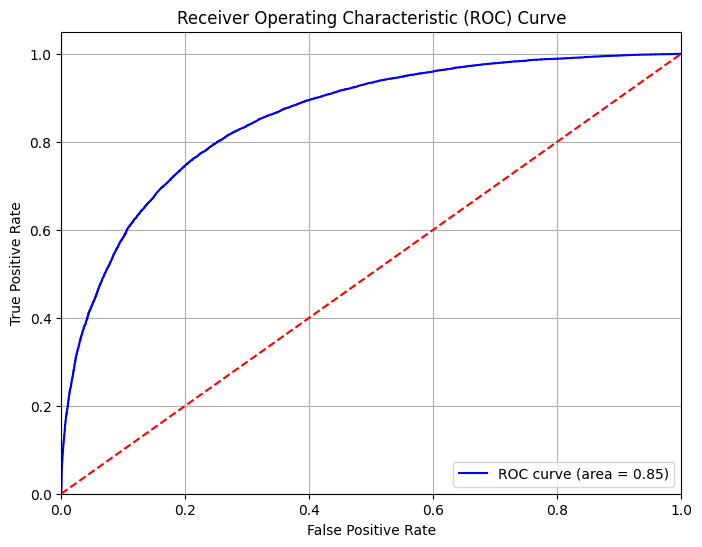

2025/10/15 16:32:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training time (seconds): 0.22


2025/10/15 16:32:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/15 16:32:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/15 16:32:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/15 16:32:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     20000
           1       0.77      0.78      0.78     20000

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



In [141]:
process_mlflow(
    run_name="lr_TFIDF_preprocess_1_wordTokenize_lemmatization",
    preprocess="preprocess_1",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    vectorizer=vectorizer,
)

## preprocess 2

Twitter_tokenize, lemmatisation

In [18]:
def tweetTokenize(text):
    tweet_tokenizer = TweetTokenizer(
        preserve_case=False,  # uniformisation en minuscules
        reduce_len=True,  # réduit les répétitions de caractères
        strip_handles=False,  # conserve les @mentions
    )
    tokens = tweet_tokenizer.tokenize(text)
    return tokens

In [42]:
def preprocess_2(text):

    # Supprimer les URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Supprimer les chiffres
    text = re.sub(r"\d+", "", text)

    # Supprimer les mentions et hashtags
    text = re.sub(r"\@\w+|\#", "", text)

    # Supprimer mots d'1 lettre
    text = re.sub(r"\b[a-z]\b", "", text)

    # Tokenisation
    tokens = tweetTokenize(text)

    # Lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [190]:
# Diviser par deux le dataset pour tester plus rapidement les modèles
df_train = df_train.sample(frac=0.5, random_state=42)
df_test = df_test.sample(frac=0.5, random_state=42)
df_val = df_val.sample(frac=0.5, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((64000, 6), (16000, 6), (20000, 6))

In [43]:
# preprocess_2 train + val + test
df_train["text_preprocess_2"] = df_train["text"].apply(preprocess_2)
df_val["text_preprocess_2"] = df_val["text"].apply(preprocess_2)
df_test["text_preprocess_2"] = df_test["text"].apply(preprocess_2)

In [37]:
df_train["text_preprocess_2"]

0        good afternoon ! last night , i had the compan...
1        taking the laptop with you make you cool , jus...
2        what are you guy doing when i'm not around , h...
3        are you and fern going to be on together soon ...
4        ok .. i like biology , i just don't like it ri...
                               ...                        
63995    hey thanks for following me ... i know alot of...
63996                         glad u guy made is back safe
63997                                    he is still alive
63998    up and at it ! another monday ha rolled around...
63999                  i wish them happiness , i really do
Name: text_preprocess_2, Length: 64000, dtype: object

In [31]:
y_train

0        1
1        1
2        0
3        0
4        0
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: target, Length: 64000, dtype: int64

In [30]:
y_train = df_train["target"]
y_test = df_test["target"]
y_val = df_val["target"]

In [195]:
# Vérification d'un échantillon
print("Exemple de texte avant/après preprocess_2:")
print("Avant:", df_train["text"].iloc[0])
print("Après:", df_train["text_preprocess_2"].iloc[0])

Exemple de texte avant/après preprocess_2:
Avant: Good afternoon!  Last night, I had the company of Shermaine through text messaging. Lovely friend I've got to known recently. 
Après: good afternoon ! last night , i had the company of shermaine through text messaging . lovely friend i've got to known recently .


In [196]:
# Vectorisation TF-IDF
X_train, X_test, vectorizer = vectorize_tf_idf(
    df_train["text_preprocess_2"], df_test["text_preprocess_2"]
)

In [198]:
X_train.shape

(64000, 75636)

## Mlflow


In [168]:
process_mlflow(
    run_name="lr_TFIDF_preprocess_2_tweetTokenize_lemmatization",
    preprocess="preprocess_2",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    vectorizer=vectorizer,
)

NameError: name 'process_mlflow' is not defined

In [ ]:
test_text = (
    "I can't believe you won't do it. I'm so happy! y'all should've seen it, cats"
)
tokens = tweetTokenize(test_text)
print("Avant:", test_text)
print("Avant:", tokens)
print("Après:", [lemmatizer.lemmatize(token) for token in tokens])
tagged = pos_tag(tokens)
lemmas_pos = [lemmatizer.lemmatize(t, tb_to_wn(tag)) for t, tag in tagged]
print("Après avec POS:", lemmas_pos)
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in tokens]
print("Après avec stemming:", stemmed)

Avant: I can't believe you won't do it. I'm so happy! y'all should've seen it, cats
Avant: ['i', "can't", 'believe', 'you', "won't", 'do', 'it', '.', "i'm", 'so', 'happy', '!', "y'all", "should've", 'seen', 'it', ',', 'cats']
Après: ['i', "can't", 'believe', 'you', "won't", 'do', 'it', '.', "i'm", 'so', 'happy', '!', "y'all", "should've", 'seen', 'it', ',', 'cat']
Après avec POS: ['i', "can't", 'believe', 'you', "won't", 'do', 'it', '.', "i'm", 'so', 'happy', '!', "y'all", "should've", 'see', 'it', ',', 'cat']
Après avec stemming: ['i', "can't", 'believ', 'you', "won't", 'do', 'it', '.', "i'm", 'so', 'happi', '!', "y'all", "should'v", 'seen', 'it', ',', 'cat']


In [ ]:
# from nltk.tokenize import TweetTokenizer
# from nltk import pos_tag

# tknzr = TweetTokenizer()
# tokens = tknzr.tokenize("I can't believe you won't do it. I'm so happy!")
# tags = pos_tag(tokens)
# print(tags)

[('I', 'PRP'), ("can't", 'VBP'), ('believe', 'VB'), ('you', 'PRP'), ("won't", 'WDT'), ('do', 'VB'), ('it', 'PRP'), ('.', '.'), ("I'm", 'NNP'), ('so', 'IN'), ('happy', 'JJ'), ('!', '.')]


## Preprocess 3

In [120]:
def preprocess_3(text):

    # Supprimer les URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Supprimer les chiffres
    text = re.sub(r"\d+", "", text)

    # Supprimer les mentions et hashtags
    text = re.sub(r"\@\w+|\#", "", text)

    # Tokenisation
    tokens = tweetTokenize(text)

    # Stemmerisation
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

In [121]:
# preprocess_3 train + test
df_train["text_preprocess_3"] = df_train["text"].apply(preprocess_3)
df_test["text_preprocess_3"] = df_test["text"].apply(preprocess_3)

In [122]:
# Vérification d'un échantillon
print("Exemple de texte avant/après preprocess_1:")
print("Avant:", df_train["text"].iloc[100])
print("Après:", df_train["text_preprocess_1"].iloc[100])

Exemple de texte avant/après preprocess_1:
Avant: Wow. Just found out that Ronald Takaki committed suicide this week.  RIP, Professor.  http://bit.ly/DbuT1
Après: wow found ronald takaki committed suicide week rip professor


In [123]:
# Vetorisation TF-IDF
X_train, X_test, vectorizer = vectorize_tf_idf(
    df_train["text_preprocess_3"], df_test["text_preprocess_3"]
)

Train Accuracy: 0.8586, Test Accuracy: 0.7945
Train Precision: 0.8558, Test Precision: 0.7936
Train Recall: 0.8626, Test Recall: 0.7962
Train F1 Score: 0.8592, Test F1 Score: 0.7949
Train ROC AUC: 0.9318, Test ROC AUC: 0.8764


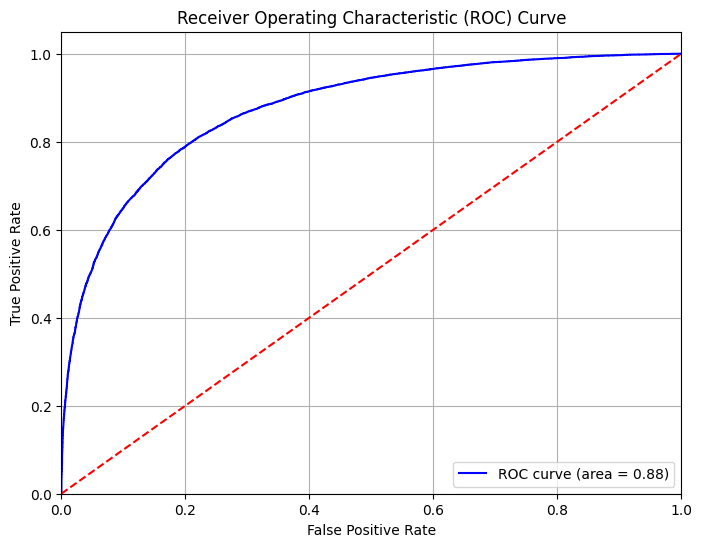

2025/10/15 16:31:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training time (seconds): 0.46


2025/10/15 16:31:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/15 16:31:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/15 16:31:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/10/15 16:31:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     20000
           1       0.79      0.80      0.79     20000

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



In [124]:
process_mlflow(
    run_name="lr_TFIDF_preprocess_3_tweetTokenize_stemming",
    preprocess="preprocess_3",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    vectorizer=vectorizer,
)

=> preprocess 2 et 3 presque identiques cependant preprocess 2 est plus rapide en terme d'execution

## Hyperparametres

In [143]:
# Diviser par deux le dataset pour tester plus rapidement les modèles
df_train = df_train.sample(frac=0.5, random_state=42)
df_test = df_test.sample(frac=0.5, random_state=42)
df_val = df_val.sample(frac=0.5, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((64000, 6), (16000, 6), (20000, 6))

In [ ]:
# df_train.to_csv("train_100K.csv", index=False)
# df_val.to_csv("val_100K.csv", index=False)
# df_test.to_csv("test_100K.csv", index=False)

In [ ]:
# def try_param_lr(X_train, X_test, y_train, y_test, model, param_grid):
    
#     from sklearn.model_selection import GridSearchCV

#     model = LogisticRegression(random_state=42)

#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring="accuracy",
#         cv=5,
#         n_jobs=-1,
#         verbose=2,
#     )

#     grid_search.fit(X_train, y_train)

#     print("Best Hyperparameters:", grid_search.best_params_)

#     best_model = grid_search.best_estimator_

#     # Prédire les probabilités pour les ensembles d'entraînement et de test
#     y_train_pred = best_model.predict(X_train)
#     y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

#     y_test_pred = best_model.predict(X_test)
#     y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

#     # Calcul des métriques
#     train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
#         calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
#     )
#     test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
#         calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
#     )

#     # Affichage des métriques train et test
#     print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
#     print(
#         f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
#     )
#     print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
#     print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
#     print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

In [ ]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "saga"],
    "penalty": ["l1", "l2"],
}
model = LogisticRegression


In [ ]:
def process_params_mlflow(
    run_name, X_train, X_test, X_val, y_train, y_test, y_val, param_grid
):
    with mlflow.start_run(run_name=run_name):

        start_time = time.time()

        model = LogisticRegression(random_state=42, max_iter=1000)

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring="accuracy",
            cv=5,
            n_jobs=-1,
            verbose=2,
            return_train_score=True,
        )
        grid_search.fit(X_train, y_train)

        training_time = time.time() - start_time
        mlflow.log_metric("training_time_seconds", training_time)

        print("Best Hyperparameters:", grid_search.best_params_)

        for param_name, param_value in grid_search.best_params_.items():
            mlflow.log_param(f"best_{param_name}", param_value)

        mlflow.log_metric("best_cv_score", grid_search.best_score_)

        best_model = grid_search.best_estimator_

        # Prédictions
        y_train_pred = best_model.predict(X_train)
        y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
        y_val_pred = best_model.predict(X_val)
        y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
        y_test_pred = best_model.predict(X_test)
        y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

        # Calcul des métriques
        train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
            calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
        )
        val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
            y_val, y_val_pred, y_val_pred_proba
        )
        test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
            calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
        )
        # Affichage des métriques train et test
        print(
            f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}"
        )
        print(
            f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
        )
        print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
        print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
        print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

        # Log des paramsètres
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_param("model_type", "LR_GS")
        mlflow.log_param("cv_folds", 5)
        mlflow.log_param("scoring", "accuracy")
        mlflow.log_param("param_grid", str(param_grid))

        # Métriques d'entraînement
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_roc_auc", train_roc_auc)

        # Métriques de validation
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)
        mlflow.log_metric("val_f1", val_f1)
        mlflow.log_metric("val_roc_auc", val_roc_auc)

        # Métriques de test
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_roc_auc", test_roc_auc)

        mlflow.log_metric("best_cv_score", grid_search.best_score_)

        # Overfitting check
        mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
        mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
        mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
        mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

        # Modèle
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path="model",
            registered_model_name="LogisticRegression_Tweets_Sentiment",
        )

        # Courbe ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {test_roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")
        plt.close()

        # Affichage du rapport de classification test
        print("\nClassification Report Test :")
        print(classification_report(y_test, y_test_pred))

        mlflow.sklearn.log_model(best_model, "best_lr_model")

        cv_results_df = pd.DataFrame(grid_search.cv_results_)
        cv_results_df.to_csv("cv_results.csv", index=False)
        mlflow.log_artifact("cv_results.csv")

        return best_model, grid_search

In [ ]:
def vectorize_tf_idf(X_train_texts, X_test_texts, X_val_texts, vectorizer=None):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.90)
    X_train = vectorizer.fit_transform(X_train_texts)
    X_test = vectorizer.transform(X_test_texts)
    X_val = vectorizer.transform(X_val_texts)
    return X_train, X_test, X_val, vectorizer




In [179]:
X_train, X_test, X_val, vectorizer = vectorize_tf_idf(
    df_train["text_preprocess_1"],
    df_test["text_preprocess_1"],
    df_val["text_preprocess_1"],
)


y_train = df_train["target"]
y_test = df_test["target"]
y_val = df_val["target"]

In [ ]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    # "penalty": ["l2", "l1"],
    # "solver": ["liblinear", "saga"],
}

best_model, grid = process_params_mlflow(
    run_name="GridSearch_LogReg_TF-IDF",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    param_grid=param_grid,  
)

In [184]:
param_grid = {
    "C": [1],
    "penalty": ["l2", "l1"],
    # "solver": ["liblinear", "saga"],
}

best_model, grid = process_params_mlflow(
    run_name="GridSearch_LogReg_TF-IDF",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    param_grid=param_grid,  # True si tu as un Model Registry
)

2025/10/16 11:49:13 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/10/16 11:49:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.4s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.4s


2025/10/16 11:49:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Train Accuracy: 0.8420, Test Accuracy: 0.7651
Train Precision: 0.8332, Test Precision: 0.7603
Train Recall: 0.8557, Test Recall: 0.7761
Train F1 Score: 0.8443, Test F1 Score: 0.7681
Train ROC AUC: 0.9176, Test ROC AUC: 0.8453


2025/10/16 11:49:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_Tweets_Sentiment' already exists. Creating a new version of this model...
Created version '3' of model 'LogisticRegression_Tweets_Sentiment'.
2025/10/16 11:49:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      9977
           1       0.76      0.78      0.77     10023

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



2025/10/16 11:49:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/16 11:49:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/10/16 11:49:22 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [187]:
param_grid = {
    "C": [1, 0.5],
    "penalty": ["l2"],
    "solver": ["saga"],
}

best_model, grid = process_params_mlflow(
    run_name="GridSearch_LogReg_TF-IDF",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    param_grid=param_grid,  # True si tu as un Model Registry
)

2025/10/16 11:50:43 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/10/16 11:50:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....................C=0.5, penalty=l2, solver=saga; total time=   0.9s
[CV] END .....................C=0.5, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....................C=0.5, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....................C=0.5, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....................C=0.5, penalty=l2, solver=saga; total time=   0.3s
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Train Accuracy: 0.8420, Test Accuracy: 0.7651
Train Precision: 0

2025/10/16 11:50:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 11:50:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_Tweets_Sentiment' already exists. Creating a new version of this model...
Created version '6' of model 'LogisticRegression_Tweets_Sentiment'.
2025/10/16 11:50:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      9977
           1       0.76      0.78      0.77     10023

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



2025/10/16 11:50:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/16 11:50:49 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/10/16 11:50:49 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


## Optuna => tfidf + RL

In [20]:
# Définir le nom de l'expérience
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [22]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
df_train.shape, df_val.shape, df_test.shape

((64000, 6), (16000, 6), (20000, 6))

In [24]:
df_train = df_train.sample(frac=0.5, random_state=42)
df_test = df_test.sample(frac=0.5, random_state=42)
df_val = df_val.sample(frac=0.5, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((32000, 6), (8000, 6), (10000, 6))

In [20]:
# preprocess_2 train + val + test
X_train = df_train["text"].apply(preprocess_2)
X_val = df_val["text"].apply(preprocess_2)
X_test = df_test["text"].apply(preprocess_2)

In [53]:
y_train = df_train["target"]
y_val = df_val["target"]
y_test = df_test["target"]

In [43]:
def objective(trial):

    # régulation
    penalty = "l2"  # trial.suggest_categorical("classifier_penalty", ["l1", "l2"])

    solver = "liblinear"  # (  trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs"]) )

    # if penalty == "l1" and solver == "lbfgs":  # Si l1 stop trial
    #     raise optuna.TrialPruned()

    # Paramètres TF-IDF
    ngram_max = trial.suggest_int("ngram_max", 2, 3)
    min_df = 5  # trial.suggest_int("min_df", 1, 2)
    max_df = 0.95  # trial.suggest_float("max_df", 0.8, 1.0)
    max_features = trial.suggest_int("max_features", 4000, 10000, step=2000)

    # Paramètre C (force de la régularisation)
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)

    # Paramètre max_iter
    max_iter = trial.suggest_int("max_iter", 100, 1000, step=100)

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, ngram_max),
                    min_df=min_df,
                    max_df=max_df,
                    max_features=max_features,
                ),
            ),
            (
                "classifier",
                LogisticRegression(
                    C=C,
                    penalty=penalty,
                    solver=solver,
                    max_iter=max_iter,
                    random_state=42,
                    n_jobs=1,  # 1 job car Optuna parallélise déjà
                ),
            ),
        ]
    )

    # Run MLflow
    with mlflow.start_run(
        nested=True
    ):  # nested=True creer un run enfant pour cet essai (run imbriqués)

        # Logger les paramètres
        params = {
            "trial_number": trial.number,
            "ngram_range": f"(1, {ngram_max})",
            "min_df": min_df,
            "max_df": max_df,
            "max_features": max_features,
            "C": C,
            "penalty": penalty,
            "solver": solver,
            "max_iter": max_iter,
        }

        mlflow.log_params(params)

        cv_scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=3,
            scoring="accuracy",
            n_jobs=1,  # Pas de parallélisation (conflit avec Optuna)
        )
        # Score mean
        mean_cv_score = cv_scores.mean()
        std_cv_scores = cv_scores.std()

        # Log des metriques
        mlflow.log_metric("cv_accuracy_mean", mean_cv_score)
        mlflow.log_metric("cv_accuracy_std", std_cv_scores)

        # Optuna optimise le score moyen
        score = mean_cv_score

        mlflow.set_tags(
            {
                "trial_number": trial.number,
                "optimizer": "optuna",
                "model": "tfidf_logreg",
            }
        )

    return score

In [44]:
# Etude optuna
study = optuna.create_study(
    study_name="optimisation_tfidf_logreg_50K",
    direction="maximize",  # Maxsimizer accuracy
    storage="sqlite:///optuna_tfidf.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5
    ),  # => Arrête les trials peu prometteurs
)
print(f"{study.study_name} OK")

[I 2025-10-22 16:32:20,953] A new study created in RDB with name: optimisation_tfidf_logreg_50K


optimisation_tfidf_logreg_50K OK


In [48]:
# Optimisation avec Mlflow (run parent)
N_TRIALS = 25
# Run
with mlflow.start_run(run_name=f"tfidf_LR_with_Optuna_50K"):
    mlflow.log_params(
        {
            "optimizer": "optuna",
            "n_trials": N_TRIALS,
            "direction": "maximize",
            "metric": "accuracy",
            "cv_folds": 3,
            "train_samples": len(X_train),
            "val_samples": len(X_val),
            "test_samples": len(X_test),
        }
    )
    # Démarrage de l'optimisation
    start_time = time.time()

    study.optimize(
        objective,
        n_trials=N_TRIALS,
        n_jobs=1,
        show_progress_bar=True,
    )

    elapsed_time = time.time() - start_time

    print(f"Trials complétés: {len(study.trials)}")

    # Meilleurs resultats
    best_trial = study.best_trial
    best_params = study.best_params
    best_value = study.best_value

    print(f"\nMeilleurs paramètres: {best_params}")

    # Logger les meilleurs résultats
    mlflow.log_metric("best_cv_accuracy", best_value)
    mlflow.log_param("best_trial_number", best_trial.number)
    for key, value in best_params.items():
        mlflow.log_param(f"best_{key}", value)

    mlflow.log_metric("optimization_time_minutes", elapsed_time / 60)
    mlflow.log_metric("total_trials", len(study.trials))

    # Entrainement du modèle

    # Recréer le pipeline avec les meilleurs paramètres
    best_pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, best_params["ngram_max"]),
                    min_df=5,  # best_params["min_df"],
                    max_df=0.95,  # best_params["max_df"],
                    max_features=best_params["max_features"],
                ),
            ),
            (
                "classifier",
                LogisticRegression(
                    C=best_params["C"],
                    penalty="l2",  # best_params["classifier_penalty"],
                    solver="liblinear",  # best_params["classifier_solver"],
                    max_iter=best_params["max_iter"],
                    random_state=42,
                    n_jobs=-1,  # Tous les CPU pour l'entraînement final
                ),
            ),
        ]
    )

    # Entraînement sur train
    model = best_pipeline.fit(X_train, y_train)
    print("Modèle final entraîné avec best_params")

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
        calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
    )
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val, y_val_pred, y_val_pred_proba
    )
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
        calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
    )

    # Affichage des métriques train et test
    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(
        f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
    )
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

    # Métriques d'entraînement
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Métriques de validation
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Métriques de test
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Overfitting check
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Courbe ROC pour tarin, val,test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train, y_train_pred_proba, "Train", "blue"),
        (y_val, y_val_pred_proba, "Validation", "green"),
        (y_test, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.savefig("roc_curve_tfidf.png")
    mlflow.log_artifact("roc_curve_tfidf.png")
    plt.close()

    # Tag Mlflow
    mlflow.set_tags(
        {
            "model_type": "optuna_tfidf_LR",
            "optimizer": "optuna",
            "dataset": "50K",
            "best_trial": best_trial.number,
        }
    )

    # Sauvegarde du modèle
    mlflow.sklearn.log_model(
        best_pipeline,
        artifact_path="model",
        registered_model_name="tfidf_logreg_optuna",
    )

Best trial: 21. Best value: 0.769094:   4%|▍         | 1/25 [00:01<00:40,  1.71s/it]

[I 2025-10-22 16:38:08,609] Trial 50 finished with value: 0.7488126118175815 and parameters: {'ngram_max': 2, 'max_features': 8000, 'C': 15.520580642188301, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:   8%|▊         | 2/25 [00:04<00:48,  2.10s/it]

[I 2025-10-22 16:38:10,976] Trial 51 finished with value: 0.7659687856768352 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 2.733539316698807, 'max_iter': 400}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  12%|█▏        | 3/25 [00:06<00:49,  2.24s/it]

[I 2025-10-22 16:38:13,401] Trial 52 finished with value: 0.7690313042380842 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.9265532079201195, 'max_iter': 400}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  16%|█▌        | 4/25 [00:08<00:49,  2.34s/it]

[I 2025-10-22 16:38:15,897] Trial 53 finished with value: 0.7630937641861734 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 5.635187731864964, 'max_iter': 300}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  20%|██        | 5/25 [00:11<00:47,  2.38s/it]

[I 2025-10-22 16:38:18,350] Trial 54 finished with value: 0.7670000679064191 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.219291779551437, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  24%|██▍       | 6/25 [00:13<00:44,  2.36s/it]

[I 2025-10-22 16:38:20,665] Trial 55 finished with value: 0.7626250288341531 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 0.3743109943192454, 'max_iter': 400}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  28%|██▊       | 7/25 [00:16<00:42,  2.39s/it]

[I 2025-10-22 16:38:23,103] Trial 56 finished with value: 0.7671875737663433 and parameters: {'ngram_max': 3, 'max_features': 6000, 'C': 0.7591592954298905, 'max_iter': 600}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  32%|███▏      | 8/25 [00:18<00:41,  2.41s/it]

[I 2025-10-22 16:38:25,573] Trial 57 finished with value: 0.760875030783921 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 6.659031575940987, 'max_iter': 400}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  36%|███▌      | 9/25 [00:21<00:38,  2.43s/it]

[I 2025-10-22 16:38:28,044] Trial 58 finished with value: 0.7690625620508894 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.6723265887937984, 'max_iter': 200}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  40%|████      | 10/25 [00:23<00:37,  2.47s/it]

[I 2025-10-22 16:38:30,593] Trial 59 finished with value: 0.7636563520806439 and parameters: {'ngram_max': 3, 'max_features': 4000, 'C': 3.147816446397338, 'max_iter': 200}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  44%|████▍     | 11/25 [00:26<00:34,  2.48s/it]

[I 2025-10-22 16:38:33,107] Trial 60 finished with value: 0.7467187983349456 and parameters: {'ngram_max': 3, 'max_features': 10000, 'C': 0.09115360482823955, 'max_iter': 200}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  48%|████▊     | 12/25 [00:28<00:32,  2.48s/it]

[I 2025-10-22 16:38:35,573] Trial 61 finished with value: 0.7690313130274214 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.6459961630015216, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  52%|█████▏    | 13/25 [00:31<00:29,  2.45s/it]

[I 2025-10-22 16:38:37,977] Trial 62 finished with value: 0.767531336462724 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.0613377203930843, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  56%|█████▌    | 14/25 [00:33<00:26,  2.45s/it]

[I 2025-10-22 16:38:40,407] Trial 63 finished with value: 0.7665625727885296 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 0.6317773718699348, 'max_iter': 600}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  60%|██████    | 15/25 [00:35<00:24,  2.46s/it]

[I 2025-10-22 16:38:42,891] Trial 64 finished with value: 0.7690937993552412 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.9203344603918628, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  64%|██████▍   | 16/25 [00:38<00:22,  2.55s/it]

[I 2025-10-22 16:38:45,659] Trial 65 finished with value: 0.7596875210156715 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 0.27481300416122006, 'max_iter': 600}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  68%|██████▊   | 17/25 [00:41<00:20,  2.55s/it]

[I 2025-10-22 16:38:48,220] Trial 66 finished with value: 0.7530000424876558 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 11.208151487991094, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  72%|███████▏  | 18/25 [00:43<00:18,  2.59s/it]

[I 2025-10-22 16:38:50,882] Trial 67 finished with value: 0.7664688169287884 and parameters: {'ngram_max': 3, 'max_features': 6000, 'C': 2.6557211410134762, 'max_iter': 300}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  76%|███████▌  | 19/25 [00:46<00:15,  2.65s/it]

[I 2025-10-22 16:38:53,684] Trial 68 finished with value: 0.7680625698616804 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.451507714183546, 'max_iter': 700}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  80%|████████  | 20/25 [00:49<00:13,  2.65s/it]

[I 2025-10-22 16:38:56,323] Trial 69 finished with value: 0.7653437817692423 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 3.576595620720848, 'max_iter': 900}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  84%|████████▍ | 21/25 [00:52<00:10,  2.65s/it]

[I 2025-10-22 16:38:58,987] Trial 70 finished with value: 0.7672188608769392 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 0.9796030910390552, 'max_iter': 100}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  88%|████████▊ | 22/25 [00:54<00:07,  2.57s/it]

[I 2025-10-22 16:39:01,365] Trial 71 finished with value: 0.7680312856808635 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 2.314475210588771, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  92%|█████████▏| 23/25 [00:56<00:05,  2.50s/it]

[I 2025-10-22 16:39:03,702] Trial 72 finished with value: 0.7690937993552412 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 1.922200577315103, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094:  96%|█████████▌| 24/25 [00:59<00:02,  2.46s/it]

[I 2025-10-22 16:39:06,060] Trial 73 finished with value: 0.7641250434859782 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 0.4730516018401285, 'max_iter': 400}. Best is trial 21 with value: 0.7690938022850203.


Best trial: 21. Best value: 0.769094: 100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


[I 2025-10-22 16:39:08,420] Trial 74 finished with value: 0.7644687798143472 and parameters: {'ngram_max': 3, 'max_features': 8000, 'C': 4.689725873527641, 'max_iter': 500}. Best is trial 21 with value: 0.7690938022850203.
Trials complétés: 75

Meilleurs paramètres: {'ngram_max': 3, 'max_features': 8000, 'C': 1.935474476346391, 'max_iter': 400}


/opt/anaconda3/envs/projet_7_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Modèle final entraîné avec best_params
Train Accuracy: 0.8417, Test Accuracy: 0.7710
Train Precision: 0.8367, Test Precision: 0.7649
Train Recall: 0.8498, Test Recall: 0.7794
Train F1 Score: 0.8432, Test F1 Score: 0.7721
Train ROC AUC: 0.9191, Test ROC AUC: 0.8498


2025/10/22 16:39:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/22 16:39:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'tfidf_logreg_optuna'.
Created version '1' of model 'tfidf_logreg_optuna'.


# Word2vec

In [1]:
from gensim.models import Word2Vec

In [74]:
train_tokens = [text.split() for text in df_train["text_preprocess_2"]]
val_tokens = [text.split() for text in df_val["text_preprocess_2"]]
test_tokens = [text.split() for text in df_test["text_preprocess_2"]]

In [75]:
modele_word2vec = Word2Vec(
    sentences=train_tokens,
    vector_size=100,  #  vector_size 100 dimensions
    window=10,  # contexte
    min_count=2,
    workers=4,
    sg=1,
    seed=42,
    epochs=10,
)
modele_word2vec

In [73]:
# Inspection du modele
print(f"Taille du vocabulaire: {len(modele_word2vec.wv)} mots")
print(f"Dimension des embeddings: {modele_word2vec.vector_size}")

Taille du vocabulaire: 15339 mots
Dimension des embeddings: 100


In [ ]:
words = modele_word2vec.wv

In [56]:
vec1 = words["good"]
vec1

array([-0.14606951,  0.2443309 , -0.16618145, -0.39835092, -0.19266507,
        0.6375418 ,  0.3082946 ,  0.69206226, -0.29387406, -0.03315203,
        0.1407305 ,  0.6681998 ,  0.13545899, -0.04654643, -0.42492375,
       -0.20002839, -0.38407487, -0.18934639, -0.5324323 ,  0.19156584,
        0.29691514, -0.03630893,  0.22086535, -0.10622748,  0.27650416,
       -0.03590391, -0.6126007 ,  0.01843317, -0.5018946 ,  0.30600595,
       -0.25211385, -0.27665663, -0.01966534,  0.24530771, -0.6240829 ,
       -0.44110784, -0.16393135, -0.49064624,  0.0424917 ,  0.14280532,
        0.25607914,  0.38413715,  0.5295669 , -0.2558547 ,  0.41900137,
       -0.08833858,  0.22970605,  0.3063318 ,  0.5627364 , -0.2193433 ,
       -0.07937307, -0.54909104,  0.45931447,  0.0348423 ,  0.01552992,
       -0.22221746,  0.21129425, -0.0902129 , -0.14876099,  0.3967147 ,
       -0.14047666,  0.10062578, -0.09225155,  0.24447569,  0.32669288,
       -0.13255861,  0.2842013 , -0.16739064, -0.01965655,  0.13

In [68]:
vec2 = words["bad"]
# similarité gensim
similarite = words.similarity("good", "bad")
print(f"Similarité gensim {similarite}")
# intrus
print("Intrus entre: good, happy, best, work ")
print(words.doesnt_match(["good", "happy", "best", "work"]))

Similarité gensim 0.5542354583740234
Intrus entre: good, happy, best, work 
work


In [78]:
# Creer les embeddings
def create_embeddings(data_tokens):
    X_data_w2v = []
    for tokens in data_tokens:
        word_vectors = []
        for token in tokens:
            if token in modele_word2vec.wv:
                vector = modele_word2vec.wv[token]
                word_vectors.append(vector)
        if len(word_vectors) > 0:
            tweet_embedding = np.mean(word_vectors, axis=0)
        else:
            tweet_embedding = np.zeros(100)  # Si aucun mot connu vecteur 0
        X_data_w2v.append(tweet_embedding)
    X_data_w2v = np.array(X_data_w2v)
    return X_data_w2v

In [79]:
# Embeddings Train
X_train_w2v = create_embeddings(train_tokens)
# Embeddings Val
X_val_w2v = create_embeddings(val_tokens)
# Embeddings Test
X_test_w2v = create_embeddings(test_tokens)

In [80]:
y_train = df_train["target"].values
y_val = df_val["target"].values
y_test = df_test["target"].values

In [81]:
X_train_w2v

array([[ 0.07551973,  0.00938368, -0.06407581, ...,  0.18204895,
        -0.15318605, -0.01367557],
       [-0.01971032,  0.01715281, -0.04675406, ...,  0.18825826,
        -0.13976344, -0.07234587],
       [ 0.1500515 ,  0.05995679, -0.06817298, ...,  0.1617144 ,
        -0.23004995, -0.06003911],
       ...,
       [ 0.12139874,  0.03876474, -0.17514214, ...,  0.44431865,
        -0.26267782,  0.0842756 ],
       [-0.10128947,  0.12634942, -0.06873481, ...,  0.25397936,
        -0.14696279,  0.02413716],
       [-0.1044376 ,  0.04425542, -0.15892135, ...,  0.17179362,
        -0.03489589, -0.0925146 ]])

In [82]:
# Optuna
def objective_word2vec(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    penalty = "l2"
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs"])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        random_state=42,
        max_iter=1000,
        n_jobs=1,
    )

    # Validation croisée sur les embeddings Word2Vec
    cv_score = cross_val_score(
        model, X_train_w2v, y_train, cv=3, scoring="accuracy", n_jobs=1
    ).mean()  # Moyenne des 3 scores

    return cv_score

In [83]:
# Etude optuna
study = optuna.create_study(
    study_name="Word2Vec_Optuna",
    direction="maximize",
    storage="sqlite:///optuna_word2vec.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(  # Arrête les trials peu prometteurs
        n_startup_trials=5  # Après 5 premiers trials
    ),
)

print(f"{study.study_name} OK")

[I 2025-10-28 13:17:54,527] A new study created in RDB with name: Word2Vec_Optuna


Word2Vec_Optuna OK


In [87]:
# Définir le nom de l'expérience
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="Word2Vec_optuna"):

    TRIAL_NUMBER = 25
    EMBEDDING_DIM = X_train_w2v.shape[1]

    # Optimisation
    start_time = time.time()
    study.optimize(
        objective_word2vec, n_trials=TRIAL_NUMBER, n_jobs=1, show_progress_bar=True
    )
    elapsed_time = time.time() - start_time

    # Log de configuration
    mlflow.log_params(
        {
            "optimizer": "optuna",
            "n_trials": TRIAL_NUMBER,
            "embedding_dim": EMBEDDING_DIM,
            "embeddings": "Word2Vec",
            "model": "LogisticRegression",
            "preprocessing": "text_preprocess_2",
            "cv_folds": 3,
            "train_samples": len(X_train_w2v),
            "val_samples": len(X_val_w2v),
            "test_samples": len(X_test_w2v),
        }
    )

    print(f"Meilleur score CV: {study.best_value:.4f}")
    print(f"Meilleurs paramètres: {study.best_params}")

    # Log résultats Optuna
    best_params = study.best_params
    mlflow.log_metrics(
        {
            "best_cv_accuracy": study.best_value,
            "optimization_time_minutes": elapsed_time / 60,
            "total_trials": len(study.trials),
        }
    )
    mlflow.log_params(
        {
            "best_C": best_params["C"],
            "best_solver": best_params["solver"],
        }
    )

    # Modèle final avec best params
    best_model = LogisticRegression(
        C=best_params["C"],
        penalty="l2",
        solver=best_params["solver"],
        random_state=42,
        max_iter=1000,
        n_jobs=-1,
    )

    model = best_model.fit(X_train_w2v, y_train)
    print("Modèle final entraîné avec best_params")

    # Prédictions
    y_train_pred = model.predict(X_train_w2v)
    y_train_pred_proba = model.predict_proba(X_train_w2v)[:, 1]
    y_val_pred = model.predict(X_val_w2v)
    y_val_pred_proba = model.predict_proba(X_val_w2v)[:, 1]
    y_test_pred = model.predict(X_test_w2v)
    y_test_pred_proba = model.predict_proba(X_test_w2v)[:, 1]

    # Métriques
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
        calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
    )
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val, y_val_pred, y_val_pred_proba
    )
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
        calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
    )

    # Affichage console
    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(
        f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
    )
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

    # Log métriques
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Overfitting checks
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Courbes ROC train/val/test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train, y_train_pred_proba, "Train", "blue"),
        (y_val, y_val_pred_proba, "Validation", "green"),
        (y_test, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test (Word2Vec)")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Sauvegarde & log de la figure
    plt.savefig("roc_curve_w2v.png")
    mlflow.log_artifact("roc_curve_w2v.png")
    plt.close()

    # Sauvegarde du modèle
    mlflow.sklearn.log_model(
        best_model,
        artifact_path="model",
        registered_model_name=f"w2v_{EMBEDDING_DIM}d_logreg",
    )

    # Tags
    mlflow.set_tags(
        {
            "model_type": "W2V_logreg",
            "embedding_type": "Word2Vec_mean",
            "optimizer": "optuna",
            "dataset": "twitter_50K",
        }
    )

Best trial: 27. Best value: 0.743188:   4%|▍         | 1/25 [00:02<00:51,  2.14s/it]

[I 2025-10-28 14:26:34,561] Trial 50 finished with value: 0.7359374761897947 and parameters: {'C': 0.014558986305195467, 'solver': 'lbfgs'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:   8%|▊         | 2/25 [00:03<00:38,  1.67s/it]

[I 2025-10-28 14:26:35,900] Trial 51 finished with value: 0.742984391719946 and parameters: {'C': 0.21054831294749465, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  12%|█▏        | 3/25 [00:04<00:34,  1.56s/it]

[I 2025-10-28 14:26:37,340] Trial 52 finished with value: 0.743031260128275 and parameters: {'C': 0.1530477796709169, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  16%|█▌        | 4/25 [00:06<00:36,  1.73s/it]

[I 2025-10-28 14:26:39,334] Trial 53 finished with value: 0.7430781549033795 and parameters: {'C': 0.6752575700258877, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  20%|██        | 5/25 [00:08<00:34,  1.71s/it]

[I 2025-10-28 14:26:40,960] Trial 54 finished with value: 0.7429219090536289 and parameters: {'C': 0.7694052875760119, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  24%|██▍       | 6/25 [00:10<00:32,  1.69s/it]

[I 2025-10-28 14:26:42,660] Trial 55 finished with value: 0.7430469095419636 and parameters: {'C': 1.3570237783721608, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  32%|███▏      | 8/25 [00:10<00:15,  1.10it/s]

[I 2025-10-28 14:26:43,002] Trial 56 finished with value: 0.7428750216026287 and parameters: {'C': 0.4034715615563083, 'solver': 'lbfgs'}. Best is trial 27 with value: 0.7431875198938237.
[I 2025-10-28 14:26:43,172] Trial 57 finished with value: 0.7174843206636831 and parameters: {'C': 0.0011887925044716822, 'solver': 'lbfgs'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  36%|███▌      | 9/25 [00:12<00:16,  1.05s/it]

[I 2025-10-28 14:26:44,525] Trial 58 finished with value: 0.7428437857625485 and parameters: {'C': 3.09373563702467, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  40%|████      | 10/25 [00:12<00:13,  1.09it/s]

[I 2025-10-28 14:26:45,149] Trial 59 finished with value: 0.7428906351282064 and parameters: {'C': 0.10295919396614156, 'solver': 'lbfgs'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  44%|████▍     | 11/25 [00:13<00:11,  1.21it/s]

[I 2025-10-28 14:26:45,768] Trial 60 finished with value: 0.7430000286826574 and parameters: {'C': 0.6394772242546233, 'solver': 'lbfgs'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 27. Best value: 0.743188:  48%|████▊     | 12/25 [00:14<00:12,  1.04it/s]

[I 2025-10-28 14:26:47,051] Trial 61 finished with value: 0.7430625216027203 and parameters: {'C': 0.2733228847030843, 'solver': 'saga'}. Best is trial 27 with value: 0.7431875198938237.


Best trial: 62. Best value: 0.743203:  52%|█████▏    | 13/25 [00:16<00:13,  1.11s/it]

[I 2025-10-28 14:26:48,499] Trial 62 finished with value: 0.7432031458703786 and parameters: {'C': 0.30335167165464777, 'solver': 'saga'}. Best is trial 62 with value: 0.7432031458703786.


Best trial: 62. Best value: 0.743203:  56%|█████▌    | 14/25 [00:18<00:14,  1.36s/it]

[I 2025-10-28 14:26:50,441] Trial 63 finished with value: 0.7429375342977735 and parameters: {'C': 1.0121712430577223, 'solver': 'saga'}. Best is trial 62 with value: 0.7432031458703786.


Best trial: 64. Best value: 0.743344:  60%|██████    | 15/25 [00:19<00:13,  1.34s/it]

[I 2025-10-28 14:26:51,727] Trial 64 finished with value: 0.7433437716028578 and parameters: {'C': 0.39132505525782074, 'solver': 'saga'}. Best is trial 64 with value: 0.7433437716028578.


Best trial: 65. Best value: 0.743359:  64%|██████▍   | 16/25 [00:20<00:12,  1.34s/it]

[I 2025-10-28 14:26:53,058] Trial 65 finished with value: 0.7433593968470021 and parameters: {'C': 0.3940199293182249, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  68%|██████▊   | 17/25 [00:22<00:10,  1.36s/it]

[I 2025-10-28 14:26:54,474] Trial 66 finished with value: 0.741828117793974 and parameters: {'C': 0.06731121089718446, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  72%|███████▏  | 18/25 [00:23<00:09,  1.35s/it]

[I 2025-10-28 14:26:55,804] Trial 67 finished with value: 0.7433593968470021 and parameters: {'C': 0.39501554637217173, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  76%|███████▌  | 19/25 [00:24<00:07,  1.32s/it]

[I 2025-10-28 14:26:57,068] Trial 68 finished with value: 0.7430781417199918 and parameters: {'C': 0.24572456423535094, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  80%|████████  | 20/25 [00:25<00:06,  1.33s/it]

[I 2025-10-28 14:26:58,400] Trial 69 finished with value: 0.7431718873255749 and parameters: {'C': 0.13621339423462991, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  84%|████████▍ | 21/25 [00:27<00:05,  1.29s/it]

[I 2025-10-28 14:26:59,599] Trial 70 finished with value: 0.7433281463587132 and parameters: {'C': 0.39867068095410413, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  88%|████████▊ | 22/25 [00:28<00:03,  1.29s/it]

[I 2025-10-28 14:27:00,882] Trial 71 finished with value: 0.7433281470911236 and parameters: {'C': 0.38983631709692246, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  92%|█████████▏| 23/25 [00:29<00:02,  1.31s/it]

[I 2025-10-28 14:27:02,245] Trial 72 finished with value: 0.7433281470911236 and parameters: {'C': 0.3886766224223183, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359:  96%|█████████▌| 24/25 [00:30<00:01,  1.26s/it]

[I 2025-10-28 14:27:03,398] Trial 73 finished with value: 0.7433593946497709 and parameters: {'C': 0.3463409343720759, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.


Best trial: 65. Best value: 0.743359: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


[I 2025-10-28 14:27:04,576] Trial 74 finished with value: 0.7433125225793896 and parameters: {'C': 0.4035032030310661, 'solver': 'saga'}. Best is trial 65 with value: 0.7433593968470021.
Meilleur score CV: 0.7434
Meilleurs paramètres: {'C': 0.3940199293182249, 'solver': 'saga'}
Modèle final entraîné avec best_params
Train Accuracy: 0.7452, Test Accuracy: 0.7358
Train Precision: 0.7484, Test Precision: 0.7410
Train Recall: 0.7397, Test Recall: 0.7267
Train F1: 0.7440, Test F1: 0.7338
Train ROC AUC: 0.8241, Test ROC AUC: 0.8141


2025/10/28 14:27:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
python(56407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/10/28 14:27:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'w2v_100d_logreg'.
Created version '1' of model 'w2v_100d_logreg'.


# GloVe

In [14]:
from gensim.models import KeyedVectors

## 25D

In [6]:
# Charger le fichier GloVe (format texte SANS header) en KeyedVectors 
path = "/Users/skanderzahi/Desktop/glove.twitter.27B/glove.twitter.27B.25d.txt"
kv = KeyedVectors.load_word2vec_format(path, binary=False, no_header=True)
print(kv.vector_size)

25


In [15]:
# Regex précompilées pour gain d'execution
# URL
_re_URL = re.compile(r"(https?://\S+|www\.\S+)")
# Mention et hashtags
_re_mention = re.compile(r"\@\w+|\#")
# Tokenisation
_tweet_tokenizer = TweetTokenizer(
    preserve_case=False, reduce_len=True, strip_handles=False
)

In [16]:
def tweetTokenize(text):
    return _tweet_tokenizer.tokenize(text)

In [17]:
def preprocess_4(text):

    text = _re_URL.sub("", text)

    text = re.sub(r"\@\w+|\#", "", text)  # Mentions et hashtags

    # Supprimer les chiffres seuls
    text = re.sub(r"\b\d+\b", "", text)

    # Tokenisation
    tokens = tweetTokenize(text)

    text = " ".join(tokens)

    return text

In [29]:
text = "Lqsssdqsd 4 coooool;!     #:)qsdqsdqsq https://www.tetx.com @ghgvh #6jhj"
preprocess_4(text)

'lqsssdqsd coool ; ! :) qsdqsdqsq 6jhj'

In [30]:
# preprocess_3 train + val + test
df_train["text_preprocess_glove"] = df_train["text"].apply(preprocess_4)
df_val["text_preprocess_glove"] = df_val["text"].apply(preprocess_4)
df_test["text_preprocess_glove"] = df_test["text"].apply(preprocess_4)

In [84]:
# Vérification d'un échantillon
print("Exemple de texte avant/après text_preprocess_glove:")
idx = 20000
print("Avant:", df_train["text"].iloc[idx])
print("Après:", df_train["text_preprocess_glove"].iloc[idx])

Exemple de texte avant/après text_preprocess_glove:
Avant: I want the rain to go away! There has been too much of it lately 
Après: i want the rain to go away ! there has been too much of it lately


In [32]:
def vectorize_doc(doc_tokens, model):

    vectors = [model[word] for word in doc_tokens if word in model]

    if vectors:  # au moins 1 mot connu
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # vecteur nul si aucun mot connu

In [33]:
df_train["glove"] = df_train["text_preprocess_glove"].apply(
    lambda doc: vectorize_doc(doc, kv)
)
df_val["glove"] = df_val["text_preprocess_glove"].apply(
    lambda doc: vectorize_doc(doc, kv)
)
df_test["glove"] = df_test["text_preprocess_glove"].apply(
    lambda doc: vectorize_doc(doc, kv)
)

In [89]:
df_train.shape

(128000, 8)

In [34]:
# Conversion en matrice nympy
X_train_glove = np.stack(df_train["glove"].values)
X_val_glove = np.stack(df_val["glove"].values)
X_test_glove = np.stack(df_test["glove"].values)

In [35]:
X_train_glove

array([[ 0.21352138,  0.11457156,  0.01155368, ...,  0.02365484,
         0.2680077 , -0.33272785],
       [ 0.18230233,  0.04558141,  0.00125615, ..., -0.05999168,
         0.26936516, -0.32877097],
       [ 0.26467943,  0.05912201,  0.00954783, ..., -0.04138768,
         0.1395708 , -0.32912165],
       ...,
       [ 0.24088505,  0.08252805,  0.01570519, ..., -0.04662155,
         0.21732092, -0.34281415],
       [ 0.30595204,  0.09139764,  0.0118228 , ..., -0.06901896,
         0.24238832, -0.35126734],
       [ 0.19691285,  0.02149937, -0.02555363, ...,  0.08218419,
         0.19953941, -0.33092466]])

In [101]:
X_train_glove.shape, X_val_glove.shape, X_test_glove.shape

((64000, 25), (16000, 25), (20000, 25))

In [122]:
y_train = df_train["target"]
y_val = df_val["target"]
y_test = df_test["target"]

In [102]:
# Conversion en DataFrame
glove_df = pd.DataFrame(X_train_glove)
print(glove_df.shape)
glove_df.head(10)

(64000, 25)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.683563,0.099428,-0.229688,-0.185015,-0.062875,0.144975,-0.026317,1.920246,-0.073857,0.011684,...,-0.483427,-0.946862,-0.035915,-0.967893,0.326951,-0.170842,-0.380092,0.409900,0.360821,0.349700
1,0.678928,0.097845,-0.170613,-0.139523,-0.178400,0.158301,-0.154635,1.851948,-0.011850,-0.063522,...,-0.353812,-0.854922,-0.024302,-0.952461,0.370596,-0.146648,-0.310857,0.358840,0.478374,0.259727
2,0.657574,0.220625,-0.164633,-0.186143,-0.113194,0.131882,-0.020022,1.886971,-0.021003,0.024397,...,-0.361414,-0.845798,-0.027195,-0.944911,0.324361,-0.182302,-0.356890,0.342174,0.368736,0.323047
3,0.725345,0.185879,-0.118584,-0.164877,0.017729,0.109055,-0.007188,1.975496,-0.168578,-0.008303,...,-0.551350,-1.020258,-0.100154,-0.887534,0.265497,-0.126399,-0.295413,0.409325,0.338336,0.421772
4,0.594795,0.099822,-0.091307,-0.214199,-0.216401,0.152448,0.136176,1.684164,-0.102608,0.264450,...,-0.395616,-0.665527,-0.116331,-0.984068,0.235169,-0.029264,-0.198324,0.260902,0.528516,0.299770
5,0.624171,-0.075879,-0.166146,-0.244411,-0.075554,0.141421,0.287842,1.706552,-0.240711,0.264446,...,-0.508429,-0.890471,-0.078428,-0.950007,-0.000625,-0.109008,-0.269541,0.257833,0.387946,0.329562
6,0.586201,0.206243,-0.283486,-0.212729,-0.146010,0.199475,-0.125786,1.886551,-0.105103,-0.134972,...,-0.316563,-0.848680,-0.007551,-0.918648,0.466142,-0.167460,-0.462902,0.465393,0.299173,0.245711
7,0.699001,0.237430,-0.221662,-0.247956,-0.053430,0.237346,0.040934,1.826516,0.088988,0.237795,...,-0.612978,-0.681874,-0.175957,-0.952437,0.368767,-0.083790,-0.318216,0.439523,0.476513,0.276996
8,0.767231,0.088743,-0.169909,-0.344879,0.136158,-0.025916,0.308373,2.222670,0.033677,0.325735,...,-0.709152,-1.089162,-0.085521,-0.808598,0.123300,-0.382298,-0.364624,0.381978,0.321825,0.428693
9,0.662448,0.113429,-0.239159,-0.304298,-0.204316,0.138914,0.263405,1.665998,-0.003148,0.224594,...,-0.474780,-0.698481,-0.134075,-1.101959,0.286647,-0.093548,-0.369766,0.419327,0.576775,0.254046


In [110]:
param_grid = {
    "C": [0.001, 0.01, 0.1, 1.0, 10.0],  # [0.01, 0.1, 1, 10],
    "penalty": ["l2", "l1"],
    "solver": ["liblinear", "saga"],
}

best_model, grid = process_params_mlflow(
    run_name="glove_25D_GridSearch_LogReg",
    X_train=X_train_glove,
    y_train=y_train,
    X_val=X_val_glove,
    y_val=y_val,
    X_test=X_test_glove,
    y_test=y_test,
    param_grid=param_grid,
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.9s
[CV] END ...................C=0.001, penalty=l1

2025/10/16 18:05:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/16 18:05:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_Tweets_Sentiment' already exists. Creating a new version of this model...
Created version '11' of model 'LogisticRegression_Tweets_Sentiment'.
2025/10/16 18:05:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.56      0.61      0.59      9977
           1       0.58      0.53      0.55     10023

    accuracy                           0.57     20000
   macro avg       0.57      0.57      0.57     20000
weighted avg       0.57      0.57      0.57     20000



2025/10/16 18:05:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 100

In [18]:
# Charger le fichier GloVe (format texte SANS header) en KeyedVectors
path = "/Users/skanderzahi/Desktop/glove.twitter.27B/glove.twitter.27B.100d.txt"
kv = KeyedVectors.load_word2vec_format(path, binary=False, no_header=True)

In [37]:
df_train["glove"] = df_train["text_preprocess_glove"].apply(
    lambda doc: vectorize_doc(doc, kv)
)
df_val["glove"] = df_val["text_preprocess_glove"].apply(
    lambda doc: vectorize_doc(doc, kv)
)
df_test["glove"] = df_test["text_preprocess_glove"].apply(
    lambda doc: vectorize_doc(doc, kv)
)
# Conversion en matrice nympy
X_train_glove = np.stack(df_train["glove"].values)
X_val_glove = np.stack(df_val["glove"].values)
X_test_glove = np.stack(df_test["glove"].values)

In [38]:
X_train_glove.shape

(32000, 100)

In [117]:
param_grid = {
    "C": [5.0],  # [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": [
        "lbfgs",
    ],
}

best_model, grid = process_params_mlflow(
    run_name="glove_100D_GridSearch_LogReg",
    X_train=X_train_glove,
    y_train=y_train,
    X_val=X_val_glove,
    y_val=y_val,
    X_test=X_test_glove,
    y_test=y_test,
    param_grid=param_grid,
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................C=5.0, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END ....................C=5.0, penalty=l2, solver=lbfgs; total time=   1.8s
[CV] END ....................C=5.0, penalty=l2, solver=lbfgs; total time=   2.0s
[CV] END ....................C=5.0, penalty=l2, solver=lbfgs; total time=   2.3s
[CV] END ....................C=5.0, penalty=l2, solver=lbfgs; total time=   3.1s
Best Hyperparameters: {'C': 5.0, 'penalty': 'l2', 'solver': 'lbfgs'}


2025/10/17 11:21:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Accuracy: 0.5975, Test Accuracy: 0.5919
Train Precision: 0.6047, Test Precision: 0.6011
Train Recall: 0.5665, Test Recall: 0.5521
Train F1 Score: 0.5850, Test F1 Score: 0.5756
Train ROC AUC: 0.6343, Test ROC AUC: 0.6274


2025/10/17 11:21:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_Tweets_Sentiment' already exists. Creating a new version of this model...
Created version '14' of model 'LogisticRegression_Tweets_Sentiment'.
2025/10/17 11:21:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.58      0.63      0.61      9977
           1       0.60      0.55      0.58     10023

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000



2025/10/17 11:21:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Optuna + MLflow

In [19]:
def glove_embedding(df_train, df_val, df_test):

    # Charger le fichier GloVe (format texte SANS header) en KeyedVectors
    path = "/Users/skanderzahi/Desktop/glove.twitter.27B/glove.twitter.27B.100d.txt"
    kv = KeyedVectors.load_word2vec_format(path, binary=False, no_header=True)

    # Regex précompilées pour gain d'execution

    # URL
    _re_URL = re.compile(r"(https?://\S+|www\.\S+)")

    # Mention et hashtags
    _re_mention_hashtag = re.compile(r"\@\w+|\#")

    # Supprimer les chiffres seuls
    _re_digits = re.compile(r"\b\d+\b")

    # Tokenisation
    _tweet_tokenizer = TweetTokenizer(
        preserve_case=False, reduce_len=True, strip_handles=False
    )

    def tweetTokenize(text):
        return _tweet_tokenizer.tokenize(text)

    def preprocess_4(text):
        text = _re_URL.sub("", text)
        text = _re_mention_hashtag.sub("", text)
        text = _re_digits.sub("", text)
        # Tokenisation
        tokens = tweetTokenize(text)
        text = " ".join(tokens)
        return text

    df_train["text_preprocess_glove"] = df_train["text"].apply(preprocess_4)
    df_val["text_preprocess_glove"] = df_val["text"].apply(preprocess_4)
    df_test["text_preprocess_glove"] = df_test["text"].apply(preprocess_4)

    def vectorize_doc(doc_tokens, model):
        vectors = [model[word] for word in doc_tokens if word in model]
        if vectors:  # au moins 1 mot connu
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(model.vector_size)  # vecteur nul si aucun mot connu

    df_train["glove"] = df_train["text_preprocess_glove"].apply(
        lambda doc: vectorize_doc(doc, kv)
    )
    df_val["glove"] = df_val["text_preprocess_glove"].apply(
        lambda doc: vectorize_doc(doc, kv)
    )
    df_test["glove"] = df_test["text_preprocess_glove"].apply(
        lambda doc: vectorize_doc(doc, kv)
    )

    X_train_glove = np.stack(df_train["glove"].values)
    X_val_glove = np.stack(df_val["glove"].values)
    X_test_glove = np.stack(df_test["glove"].values)

    y_train = df_train["target"]
    y_val = df_val["target"]
    y_test = df_test["target"]

    return X_train_glove, X_val_glove, X_test_glove, y_train, y_val, y_test

In [21]:
df_train.shape, df_val.shape, df_test.shape

((64000, 6), (16000, 6), (20000, 6))

In [22]:
df_train = df_train.sample(frac=0.5, random_state=42)
df_test = df_test.sample(frac=0.5, random_state=42)
df_val = df_val.sample(frac=0.5, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((32000, 6), (8000, 6), (10000, 6))

In [23]:
X_train_glove, X_val_glove, X_test_glove, y_train, y_val, y_test = glove_embedding(
    df_train, df_val, df_test
)

In [24]:
X_train_glove.shape

(32000, 100)

In [32]:
# Définir le nom de l'expérience
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/skanderzahi/Desktop/P7/projet/mlruns/379503310426968982', creation_time=1760449044952, experiment_id='379503310426968982', last_update_time=1760449044952, lifecycle_stage='active', name='p7_air_paradis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [33]:
def objective_glove(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    penalty = "l2"
    solver = "liblinear"

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        random_state=42,
        n_jobs=1,
    )
    # Validation croisée sur les embeddings GloVe
    cv_score = cross_val_score(
        model, X_train_glove, y_train, cv=3, scoring="accuracy", n_jobs=1
    ).mean()

    return cv_score

In [35]:
# Etude optuna
study = optuna.create_study(
    study_name="GloVe_Optuna",
    direction="maximize",  # Maxsimizer accuracy
    storage="sqlite:///optuna_glove.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5
    ),  # => Arrête les trials peu prometteurs
)
print(f"{study.study_name} OK")

[I 2025-10-22 19:26:14,249] Using an existing study with name 'GloVe_Optuna' instead of creating a new one.


GloVe_Optuna OK


In [ ]:
# mlflow
with mlflow.start_run(run_name="GloVe_optuna"):

    TRIAL_NUMBER = 25
    EMBEDDING_DIM = X_train_glove.shape[1]

    # Optimisation
    start_time = time.time()

    study.optimize(
        objective_glove, n_trials=TRIAL_NUMBER, n_jobs=1, show_progress_bar=True
    )

    elapsed_time = time.time() - start_time

    # Log de configuration
    mlflow.log_params(
        {
            "optimizer": "optuna",
            "n_trials": TRIAL_NUMBER,
            "embedding_dim": EMBEDDING_DIM,
            "embeddings": "GloVe",
            "model": "LogisticRegression",
            "preprocessing": "preprocess_4",
            "cv_folds": 3,
            "train_samples": len(X_train_glove),
            "val_samples": len(X_val_glove),
            "test_samples": len(X_test_glove),
        }
    )

    print(f"Meilleur score CV: {study.best_value:.4f}")
    print(f" Meilleurs paramètres: {study.best_params}")

    # Log des résultats optimisation
    best_params = study.best_params

    mlflow.log_metrics(
        {
            "best_cv_accuracy": study.best_value,
            "optimization_time_minutes": elapsed_time / 60,
            "total_trials": len(study.trials),
        }
    )

    mlflow.log_params(
        {
            "best_C": best_params["C"],
        }
    )

    # solver = "liblinear" if best_params["penalty"] == "l1" else "lbfgs"
    # Construction et entraînement du meilleur modèle
    best_model = LogisticRegression(
        C=best_params["C"],
        penalty="l2",
        solver="liblinear",
        random_state=42,
        n_jobs=-1,
    )

    model = best_model.fit(X_train_glove, y_train)
    print("Modèle final entraîné avec best_params")

    # Prédictions
    y_train_pred = model.predict(X_train_glove)
    y_train_pred_proba = model.predict_proba(X_train_glove)[:, 1]
    y_val_pred = model.predict(X_val_glove)
    y_val_pred_proba = model.predict_proba(X_val_glove)[:, 1]
    y_test_pred = model.predict(X_test_glove)
    y_test_pred_proba = model.predict_proba(X_test_glove)[:, 1]

    # Calcul des métriques
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
        calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
    )
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val, y_val_pred, y_val_pred_proba
    )
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
        calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
    )

    # Affichage des métriques train et test
    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(
        f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
    )
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

    # Métriques train
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Métriques val
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Métriques test
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Overfitting check
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Courbe ROC pour train, val,test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train, y_train_pred_proba, "Train", "blue"),
        (y_val, y_val_pred_proba, "Validation", "green"),
        (y_test, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Sauvegarder l'image
    plt.savefig("roc_curve_glove.png")
    mlflow.log_artifact("roc_curve_glove.png")
    plt.close()

    # Sauvegarde du modèle
    mlflow.sklearn.log_model(
        best_model,
        artifact_path="model",
        registered_model_name=f"glove_{EMBEDDING_DIM}d_logreg",
    )
    # Taggs
    mlflow.set_tags(
        {
            "model_type": "GloVe_logreg",
            "embedding_type": "GloVe",
            "optimizer": "optuna",
            "dataset": "twitter_50K",
        }
    )

Best trial: 42. Best value: 0.599281:   4%|▍         | 1/25 [00:04<01:58,  4.95s/it]

[I 2025-10-22 21:44:24,238] Trial 133 finished with value: 0.5988749132763425 and parameters: {'C': 80.99505524998528}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:   8%|▊         | 2/25 [00:08<01:29,  3.88s/it]

[I 2025-10-22 21:44:27,368] Trial 134 finished with value: 0.5989061417913569 and parameters: {'C': 38.917377782689684}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  12%|█▏        | 3/25 [00:11<01:20,  3.65s/it]

[I 2025-10-22 21:44:30,739] Trial 135 finished with value: 0.5990311583936826 and parameters: {'C': 65.19342147200858}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  16%|█▌        | 4/25 [00:15<01:17,  3.70s/it]

[I 2025-10-22 21:44:34,530] Trial 136 finished with value: 0.5991249171832029 and parameters: {'C': 97.8000659484504}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  20%|██        | 5/25 [00:19<01:17,  3.87s/it]

[I 2025-10-22 21:44:38,708] Trial 137 finished with value: 0.5991249142534237 and parameters: {'C': 97.14399701885931}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  24%|██▍       | 6/25 [00:22<01:09,  3.66s/it]

[I 2025-10-22 21:44:41,960] Trial 138 finished with value: 0.5989373996041623 and parameters: {'C': 49.38082454181492}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  28%|██▊       | 7/25 [00:25<01:03,  3.55s/it]

[I 2025-10-22 21:44:45,272] Trial 139 finished with value: 0.5988436583933163 and parameters: {'C': 69.7381219425058}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  32%|███▏      | 8/25 [00:29<01:01,  3.60s/it]

[I 2025-10-22 21:44:48,986] Trial 140 finished with value: 0.5991874152301389 and parameters: {'C': 98.51560585333273}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  36%|███▌      | 9/25 [00:33<00:57,  3.62s/it]

[I 2025-10-22 21:44:52,657] Trial 141 finished with value: 0.5988436583933163 and parameters: {'C': 78.67861889831522}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  40%|████      | 10/25 [00:36<00:53,  3.60s/it]

[I 2025-10-22 21:44:56,191] Trial 142 finished with value: 0.5990311583936826 and parameters: {'C': 59.070565750812165}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  44%|████▍     | 11/25 [00:41<00:53,  3.79s/it]

[I 2025-10-22 21:45:00,416] Trial 143 finished with value: 0.59915616913645 and parameters: {'C': 99.88510023556462}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  48%|████▊     | 12/25 [00:44<00:46,  3.58s/it]

[I 2025-10-22 21:45:03,511] Trial 144 finished with value: 0.5989373966743833 and parameters: {'C': 46.22607777814541}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  52%|█████▏    | 13/25 [00:47<00:42,  3.57s/it]

[I 2025-10-22 21:45:07,060] Trial 145 finished with value: 0.5988124064400693 and parameters: {'C': 74.64422642333375}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  56%|█████▌    | 14/25 [00:50<00:36,  3.30s/it]

[I 2025-10-22 21:45:09,725] Trial 146 finished with value: 0.598874895697668 and parameters: {'C': 39.638314594134215}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  60%|██████    | 15/25 [00:54<00:35,  3.57s/it]

[I 2025-10-22 21:45:13,936] Trial 147 finished with value: 0.5989374171828366 and parameters: {'C': 83.98638372836598}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  64%|██████▍   | 16/25 [00:58<00:33,  3.73s/it]

[I 2025-10-22 21:45:18,031] Trial 148 finished with value: 0.5991249142534237 and parameters: {'C': 99.80235353839578}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  68%|██████▊   | 17/25 [01:02<00:28,  3.62s/it]

[I 2025-10-22 21:45:21,383] Trial 149 finished with value: 0.5990311554639035 and parameters: {'C': 60.15184682285308}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  72%|███████▏  | 18/25 [01:05<00:24,  3.52s/it]

[I 2025-10-22 21:45:24,683] Trial 150 finished with value: 0.5989061564402524 and parameters: {'C': 67.5561413911823}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  76%|███████▌  | 19/25 [01:08<00:21,  3.50s/it]

[I 2025-10-22 21:45:28,140] Trial 151 finished with value: 0.5989374113232785 and parameters: {'C': 52.318882233613365}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  80%|████████  | 20/25 [01:13<00:18,  3.70s/it]

[I 2025-10-22 21:45:32,300] Trial 152 finished with value: 0.599218670113165 and parameters: {'C': 99.25301167351618}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  84%|████████▍ | 21/25 [01:17<00:15,  3.93s/it]

[I 2025-10-22 21:45:36,782] Trial 153 finished with value: 0.59915616913645 and parameters: {'C': 99.94479510664065}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  88%|████████▊ | 22/25 [01:21<00:11,  3.87s/it]

[I 2025-10-22 21:45:40,505] Trial 154 finished with value: 0.5989061593700314 and parameters: {'C': 71.11693554106998}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  92%|█████████▏| 23/25 [01:22<00:06,  3.10s/it]

[I 2025-10-22 21:45:41,802] Trial 155 finished with value: 0.5964686300674799 and parameters: {'C': 1.8949211846300202}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281:  96%|█████████▌| 24/25 [01:26<00:03,  3.31s/it]

[I 2025-10-22 21:45:45,622] Trial 156 finished with value: 0.5988749103465634 and parameters: {'C': 79.3342085248064}. Best is trial 42 with value: 0.599281168160101.


Best trial: 42. Best value: 0.599281: 100%|██████████| 25/25 [01:30<00:00,  3.61s/it]
/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


[I 2025-10-22 21:45:49,615] Trial 157 finished with value: 0.5991561662066709 and parameters: {'C': 96.86727474485859}. Best is trial 42 with value: 0.599281168160101.
Meilleur score CV: 0.5993
 Meilleurs paramètres: {'C': 98.29105404540472}
Modèle final entraîné avec best_params
Train Accuracy: 0.6009, Test Accuracy: 0.5914
Train Precision: 0.6089, Test Precision: 0.5972
Train Recall: 0.5677, Test Recall: 0.5501
Train F1 Score: 0.5876, Test F1 Score: 0.5727
Train ROC AUC: 0.6384, Test ROC AUC: 0.6277


2025/10/22 21:45:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/22 21:45:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'glove_100d_logreg'.
Created version '1' of model 'glove_100d_logreg'.


# USE

In [42]:
import tensorflow_hub as hub

/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [43]:
# Chargement du modèle
model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [45]:
def preprocess_5_use(text):

    text = text.lower()

    text = _re_URL.sub("", text)

    text = re.sub(r"\@\w+|\#", "", text)  # Mentions et hashtags

    # Supprimer les chiffres seuls
    text = re.sub(r"\b\d+\b", "", text)

    # Supprimer espaces multiples
    text = re.sub(r"\s+", " ", text)
    text = text.strip()

    # pas d'utilité de tokenisation pour use (attend txt brut)
    # Tokenisation
    # tokens = tweetTokenize(text)

    return text

In [46]:
# preprocess_4 train + val + test
df_train["text_preprocess_use"] = df_train["text"].apply(preprocess_5_use)
df_val["text_preprocess_use"] = df_val["text"].apply(preprocess_5_use)
df_test["text_preprocess_use"] = df_test["text"].apply(preprocess_5_use)

In [47]:
def vectorize_use_with_batch(text, model, batch_size=1000):
    all_embeddings = []

    for i in range(0, len(text), batch_size):
        batch = text[i : i + batch_size]
        batch_embeddings = model(batch)
        all_embeddings.append(batch_embeddings.numpy())
    return np.vstack(all_embeddings)

In [48]:
list_train = df_train["text_preprocess_use"].tolist()
list_val = df_val["text_preprocess_use"].tolist()
list_test = df_test["text_preprocess_use"].tolist()

In [49]:
X_train_use = vectorize_use_with_batch(list_train, model_use)
X_val_use = vectorize_use_with_batch(list_val, model_use)
X_test_use = vectorize_use_with_batch(list_test, model_use)

In [50]:
X_train_use.shape

(32000, 512)

In [129]:
param_grid = {
    "C": [
        2.0,
        5.0,
        10.0,
    ],  # [0.001, 0.01, 0.1, 1.0, 10.0],  # [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear", "saga", "lbfgs"],
}

best_model, grid = process_params_mlflow(
    run_name="USE_GridSearch_LogReg",
    X_train=X_train_use,
    y_train=y_train,
    X_val=X_val_use,
    y_val=y_val,
    X_test=X_test_use,
    y_test=y_test,
    param_grid=param_grid,
)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................C=2.0, penalty=l2, solver=saga; total time=  43.3s
[CV] END .....................C=2.0, penalty=l2, solver=saga; total time=  43.5s
[CV] END .....................C=2.0, penalty=l2, solver=saga; total time=  43.7s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=  10.1s
[CV] END .....................C=2.0, penalty=l2, solver=saga; total time=  13.3s
[CV] END .....................C=2.0, penalty=l2, solver=saga; total time=  15.6s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   6.2s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   2.7s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=   6.9s
[CV] END ....................C=2.0, penalty=l2, solver=lbfgs; total time=  10.5s
[CV] END ................C=2.0, penalty=l2, solver=liblinear; total time=  57.9s
[CV] END ................C=2.0, penalty=l2, solve

2025/10/17 14:22:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
python(41126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/10/17 14:22:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_Tweets_Sentiment' already exists. Creating a new version of this model...
Created version '17' of model 'LogisticRegression_Tweets_Sentiment'.
2025/10/17 14:22:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Classification Report Test :
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      9977
           1       0.79      0.78      0.78     10023

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



python(41147) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025/10/17 14:22:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Optuna + MLflow

In [ ]:
# Définir le nom de l'expérience
experiment_name = "p7_air_paradis"
mlflow.set_experiment(experiment_name)

In [51]:
def objective_use(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    penalty = "l2"
    solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs"])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        random_state=42,
        n_jobs=1,
    )
    # Validation croisée sur les embeddings GloVe
    cv_score = cross_val_score(
        model, X_train_glove, y_train, cv=3, scoring="accuracy", n_jobs=1
    ).mean()

    return cv_score

In [52]:
# Etude optuna
study = optuna.create_study(
    study_name="USE_Optuna",
    direction="maximize",  # Maxsimizer accuracy
    storage="sqlite:///optuna_use.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5
    ),  # => Arrête les trials peu prometteurs
)
print(f"{study.study_name} OK")

[I 2025-10-22 21:57:26,830] A new study created in RDB with name: USE_Optuna


USE_Optuna OK


In [53]:
# Etude optuna
with mlflow.start_run(run_name="USE_optuna"):

    TRIAL_NUMBER = 25
    EMBEDDING_DIM = X_train_use.shape[1]

    # Optimisation
    start_time = time.time()

    study.optimize(
        objective_use, n_trials=TRIAL_NUMBER, n_jobs=1, show_progress_bar=True
    )

    elapsed_time = time.time() - start_time

    # Log de configuration
    mlflow.log_params(
        {
            "optimizer": "optuna",
            "n_trials": TRIAL_NUMBER,
            "embedding_dim": EMBEDDING_DIM,
            "embeddings": "USE",
            "model": "LogisticRegression",
            "preprocessing": "preprocess_use",
            "cv_folds": 3,
            "train_samples": len(X_train_use),
            "val_samples": len(X_val_use),
            "test_samples": len(X_test_use),
        }
    )

    print(f"Meilleur score CV: {study.best_value:.4f}")
    print(f" Meilleurs paramètres: {study.best_params}")

    # Log des résultats optimisation
    best_params = study.best_params

    mlflow.log_metrics(
        {
            "best_cv_accuracy": study.best_value,
            "optimization_time_minutes": elapsed_time / 60,
            "total_trials": len(study.trials),
        }
    )

    mlflow.log_params(
        {
            "best_C": best_params["C"],
        }
    )

    # solver = "liblinear" if best_params["penalty"] == "l1" else "lbfgs"
    # Construction et entraînement du meilleur modèle
    best_model = LogisticRegression(
        C=best_params["C"],
        penalty="l2",
        solver=best_params["solver"],
        random_state=42,
        n_jobs=-1,
    )

    model = best_model.fit(X_train_use, y_train)
    print("Modèle final entraîné avec best_params")

    # Prédictions
    y_train_pred = model.predict(X_train_use)
    y_train_pred_proba = model.predict_proba(X_train_use)[:, 1]
    y_val_pred = model.predict(X_val_use)
    y_val_pred_proba = model.predict_proba(X_val_use)[:, 1]
    y_test_pred = model.predict(X_test_use)
    y_test_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Calcul des métriques
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = (
        calcul_metriques(y_train, y_train_pred, y_train_pred_proba)
    )
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = calcul_metriques(
        y_val, y_val_pred, y_val_pred_proba
    )
    test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = (
        calcul_metriques(y_test, y_test_pred, y_test_pred_proba)
    )

    # Affichage des métriques train et test
    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(
        f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}"
    )
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

    # Métriques d'entraînement
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_roc_auc", train_roc_auc)

    # Métriques de validation
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("val_roc_auc", val_roc_auc)

    # Métriques de test
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Overfitting check
    mlflow.log_metric("train_val_accuracy_gap", train_accuracy - val_accuracy)
    mlflow.log_metric("val_test_accuracy_gap", val_accuracy - test_accuracy)
    mlflow.log_metric("train_val_f1_gap", train_f1 - val_f1)
    mlflow.log_metric("val_test_f1_gap", val_f1 - test_f1)

    # Courbe ROC pour tarin, val,test
    plt.figure(figsize=(8, 6))
    for y_true, y_proba, label, color in [
        (y_train, y_train_pred_proba, "Train", "blue"),
        (y_val, y_val_pred_proba, "Validation", "green"),
        (y_test, y_test_pred_proba, "Test", "red"),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Train/Validation/Test")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Sauvegarder l'image
    plt.savefig("roc_curve_use.png")
    mlflow.log_artifact("roc_curve_use.png")
    plt.close()

    # Sauvegarde du modèle
    mlflow.sklearn.log_model(
        best_model,
        artifact_path="model",
        registered_model_name=f"use_{EMBEDDING_DIM}d_logreg",
    )
    # Taggs
    mlflow.set_tags(
        {
            "model_type": "USE_logreg",
            "embedding_type": "USE",
            "optimizer": "optuna",
            "dataset": "twitter_50K",
        }
    )

Best trial: 0. Best value: 0.584312:   8%|▊         | 2/25 [00:01<00:16,  1.37it/s]

[I 2025-10-22 22:07:27,377] Trial 0 finished with value: 0.5843124259436084 and parameters: {'C': 0.07459343285726547, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5843124259436084.
[I 2025-10-22 22:07:27,564] Trial 1 finished with value: 0.5633750147726785 and parameters: {'C': 0.006026889128682512, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5843124259436084.


/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Best trial: 2. Best value: 0.595906:  12%|█▏        | 3/25 [00:02<00:14,  1.56it/s]

[I 2025-10-22 22:07:28,096] Trial 2 finished with value: 0.595906115417486 and parameters: {'C': 1.0129197956845737, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.595906115417486.


Best trial: 3. Best value: 0.598594:  16%|█▌        | 4/25 [00:04<00:28,  1.35s/it]

[I 2025-10-22 22:07:30,544] Trial 3 finished with value: 0.5985936574162349 and parameters: {'C': 14.528246637516036, 'solver': 'liblinear'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 3. Best value: 0.598594:  20%|██        | 5/25 [00:05<00:20,  1.02s/it]

[I 2025-10-22 22:07:30,959] Trial 4 finished with value: 0.580312392731633 and parameters: {'C': 0.033205591037519584, 'solver': 'liblinear'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 3. Best value: 0.598594:  24%|██▍       | 6/25 [00:05<00:14,  1.30it/s]

[I 2025-10-22 22:07:31,257] Trial 5 finished with value: 0.5955936163934686 and parameters: {'C': 1.1462107403425035, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 3. Best value: 0.598594:  28%|██▊       | 7/25 [00:06<00:13,  1.35it/s]

[I 2025-10-22 22:07:31,941] Trial 6 finished with value: 0.5897811368905691 and parameters: {'C': 0.19069966103000435, 'solver': 'liblinear'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 3. Best value: 0.598594:  32%|███▏      | 8/25 [00:09<00:26,  1.58s/it]

[I 2025-10-22 22:07:35,307] Trial 7 finished with value: 0.594343614437841 and parameters: {'C': 0.9163741808778781, 'solver': 'saga'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 3. Best value: 0.598594:  36%|███▌      | 9/25 [00:10<00:21,  1.33s/it]

[I 2025-10-22 22:07:36,108] Trial 8 finished with value: 0.5553438780417823 and parameters: {'C': 0.0021147447960615704, 'solver': 'saga'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 3. Best value: 0.598594:  40%|████      | 10/25 [00:10<00:16,  1.12s/it]

[I 2025-10-22 22:07:36,755] Trial 9 finished with value: 0.580312392731633 and parameters: {'C': 0.03334792728637585, 'solver': 'saga'}. Best is trial 3 with value: 0.5985936574162349.


Best trial: 10. Best value: 0.598969:  44%|████▍     | 11/25 [00:14<00:25,  1.84s/it]

[I 2025-10-22 22:07:40,213] Trial 10 finished with value: 0.5989686632765255 and parameters: {'C': 53.17196633982102, 'solver': 'liblinear'}. Best is trial 10 with value: 0.5989686632765255.


Best trial: 10. Best value: 0.598969:  48%|████▊     | 12/25 [00:18<00:31,  2.40s/it]

[I 2025-10-22 22:07:43,885] Trial 11 finished with value: 0.5988436583933163 and parameters: {'C': 70.41830285015996, 'solver': 'liblinear'}. Best is trial 10 with value: 0.5989686632765255.


Best trial: 10. Best value: 0.598969:  52%|█████▏    | 13/25 [00:22<00:35,  3.00s/it]

[I 2025-10-22 22:07:48,243] Trial 12 finished with value: 0.5989374142530576 and parameters: {'C': 83.0652918540325, 'solver': 'liblinear'}. Best is trial 10 with value: 0.5989686632765255.


Best trial: 13. Best value: 0.599062:  56%|█████▌    | 14/25 [00:26<00:37,  3.38s/it]

[I 2025-10-22 22:07:52,548] Trial 13 finished with value: 0.5990624132767087 and parameters: {'C': 86.78117058240957, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5990624132767087.


Best trial: 13. Best value: 0.599062:  60%|██████    | 15/25 [00:28<00:29,  2.97s/it]

[I 2025-10-22 22:07:54,548] Trial 14 finished with value: 0.5981874113218136 and parameters: {'C': 10.295416203258752, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5990624132767087.


Best trial: 13. Best value: 0.599062:  64%|██████▍   | 16/25 [00:30<00:24,  2.77s/it]

[I 2025-10-22 22:07:56,861] Trial 15 finished with value: 0.5982811583922176 and parameters: {'C': 11.74521955182741, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5990624132767087.


Best trial: 13. Best value: 0.599062:  68%|██████▊   | 17/25 [00:32<00:19,  2.48s/it]

[I 2025-10-22 22:07:58,669] Trial 16 finished with value: 0.5974061593671016 and parameters: {'C': 4.071532309445411, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5990624132767087.


Best trial: 13. Best value: 0.599062:  72%|███████▏  | 18/25 [00:35<00:18,  2.67s/it]/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[I 2025-10-22 22:08:01,781] Trial 17 finished with value: 0.5990311437447873 and parameters: {'C': 35.968465875065895, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5990624132767087.


/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Best trial: 13. Best value: 0.599062:  76%|███████▌  | 19/25 [00:36<00:11,  1.99s/it]

[I 2025-10-22 22:08:02,200] Trial 18 finished with value: 0.5968124308509883 and parameters: {'C': 3.4489137283274562, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.5990624132767087.


/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Best trial: 13. Best value: 0.599062:  80%|████████  | 20/25 [00:41<00:15,  3.03s/it]

[I 2025-10-22 22:08:07,624] Trial 19 finished with value: 0.5979999083916684 and parameters: {'C': 27.00934013350801, 'solver': 'saga'}. Best is trial 13 with value: 0.5990624132767087.


Best trial: 13. Best value: 0.599062:  84%|████████▍ | 21/25 [00:45<00:12,  3.11s/it]

[I 2025-10-22 22:08:10,922] Trial 20 finished with value: 0.5971561613197993 and parameters: {'C': 3.3035210767721015, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5990624132767087.


Best trial: 21. Best value: 0.599094:  88%|████████▊ | 22/25 [00:49<00:10,  3.49s/it]

[I 2025-10-22 22:08:15,294] Trial 21 finished with value: 0.5990936652299558 and parameters: {'C': 97.35761991652669, 'solver': 'liblinear'}. Best is trial 21 with value: 0.5990936652299558.


Best trial: 21. Best value: 0.599094:  92%|█████████▏| 23/25 [00:52<00:06,  3.30s/it]

[I 2025-10-22 22:08:18,169] Trial 22 finished with value: 0.5986561496036128 and parameters: {'C': 27.92629080421768, 'solver': 'liblinear'}. Best is trial 21 with value: 0.5990936652299558.


Best trial: 23. Best value: 0.599187:  96%|█████████▌| 24/25 [00:56<00:03,  3.65s/it]

[I 2025-10-22 22:08:22,638] Trial 23 finished with value: 0.5991874181599179 and parameters: {'C': 96.03701351493427, 'solver': 'liblinear'}. Best is trial 23 with value: 0.5991874181599179.


Best trial: 23. Best value: 0.599187: 100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


[I 2025-10-22 22:08:26,762] Trial 24 finished with value: 0.5991561632768918 and parameters: {'C': 92.00547882331126, 'solver': 'liblinear'}. Best is trial 23 with value: 0.5991874181599179.
Meilleur score CV: 0.5992
 Meilleurs paramètres: {'C': 96.03701351493427, 'solver': 'liblinear'}


/opt/anaconda3/envs/glove_test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Modèle final entraîné avec best_params
Train Accuracy: 0.7892, Test Accuracy: 0.7776
Train Precision: 0.7912, Test Precision: 0.7750
Train Recall: 0.7866, Test Recall: 0.7794
Train F1 Score: 0.7889, Test F1 Score: 0.7772
Train ROC AUC: 0.8703, Test ROC AUC: 0.8568


2025/10/22 22:08:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/22 22:08:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'use_512d_logreg'.
Created version '1' of model 'use_512d_logreg'.
